In [ ]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy.matlib
import scipy.optimize
import matplotlib.image as mpimg
from scipy.spatial import distance
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal, norm
from sklearn import mixture
from scipy.optimize import minimize
from scipy.optimize import nnls
from sklearn.linear_model import Lasso
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from numpy import linalg as LA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

%matplotlib inline

In [ ]:
Pavia = sio.loadmat('PaviaU_cube.mat')
HSI = Pavia['X']
print(HSI)

[[[ 903  763  658 ... 2988 3036 3045]
  [ 817  937  864 ... 3412 3484 3503]
  [ 811  857  905 ... 2965 2977 2983]
  ...
  [1088 1141 1163 ... 1275 1253 1257]
  [1264 1244 1023 ... 1251 1213 1240]
  [1370 1262 1222 ... 1277 1295 1336]]

 [[1234  967  733 ... 2746 2779 2843]
  [ 740  930  923 ... 2641 2711 2737]
  [1292 1106  923 ... 2314 2364 2389]
  ...
  [1143 1095 1131 ... 1300 1299 1327]
  [1498 1302 1199 ... 1298 1262 1286]
  [ 777  573  844 ... 1292 1316 1340]]

 [[1377 1269  987 ... 2617 2663 2727]
  [1157  953  836 ... 2410 2429 2444]
  [1268 1209  997 ... 2205 2229 2236]
  ...
  [1151 1235 1270 ... 1433 1427 1440]
  [1478 1389 1299 ... 1330 1315 1308]
  [1170 1334 1238 ... 1295 1230 1217]]

 ...

 [[ 649  597  635 ... 2665 2736 2786]
  [ 853  886  718 ... 3476 3573 3594]
  [ 846  584  347 ... 3586 3589 3599]
  ...
  [ 519  436  479 ... 3857 3792 3831]
  [ 744  373  136 ... 3472 3467 3495]
  [ 708  374  518 ... 3461 3498 3575]]

 [[ 617  431  570 ... 2777 2804 2793]
  [ 735  576

In [ ]:
M = HSI.shape[0]
N = HSI.shape[1]
print("M size is: ",M)
print("N size is: ",N)

M size is:  300
N size is:  200


In [ ]:
ends = sio.loadmat('PaviaU_endmembers.mat')
endmembers = ends['endmembers']
print(endmembers)

[[1091.88718412  935.31299927 1260.85040495  689.59934319 2914.08309456
   895.41715976 1087.77969925 1245.21671309  642.72114137]
 [1053.39440433  857.3761801  1255.74416389  560.56157635 2994.92406877
   835.75772518 1084.84887218 1228.80668524  532.25162127]
 [1043.06588448  817.46114742 1238.04001906  484.6453202  3101.07163324
   798.19296515 1099.9112782  1233.85849582  435.59922179]
 [1073.37274368  820.48148148 1264.69938066  469.54351396 3342.28653295
   824.88527285 1147.01654135 1290.57604457  392.13488975]
 [1096.81768953  818.1815541  1291.67698904  455.98850575 3585.61318052
   855.34319527 1186.36541353 1335.91030641  373.07652399]
 [1101.86552347  807.85257807 1290.99285374  429.9408867  3755.61747851
   863.88856016 1201.69849624 1348.54150418  352.45006485]
 [1104.07761733  796.62745098 1295.09718914  408.19047619 3898.53868195
   870.18474688 1217.10902256 1356.49359331  334.82230869]
 [1094.05054152  776.33405955 1284.23058599  383.47619048 4009.76074499
   873.9082

In [ ]:
print("The size of our endmembers is: ",len(endmembers))

The size of our endmembers is:  103


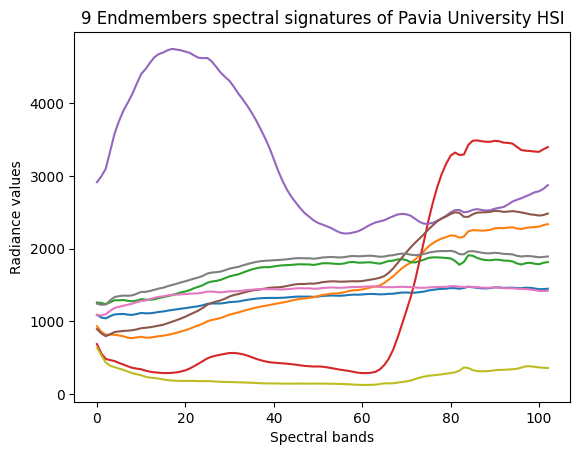

In [ ]:
fig = plt.figure()
plt.plot(endmembers)
plt.ylabel('Radiance values')
plt.xlabel('Spectral bands')
plt.title('9 Endmembers spectral signatures of Pavia University HSI')
plt.show()

In [ ]:
L = HSI.shape[2]
pixels= M*N

In [ ]:
ground_truth = sio.loadmat('PaviaU_ground_truth.mat')
truth = ground_truth['y']
labels = truth.reshape((pixels,1))
print(labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


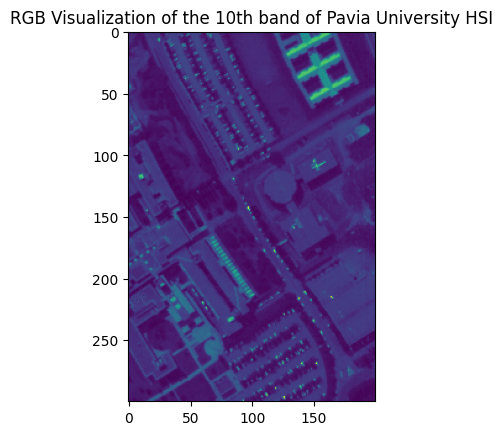

In [ ]:
fig = plt.figure()
plt.imshow(HSI[:,:,10])
plt.title('RGB Visualization of the 10th band of Pavia University HSI')
plt.show()

In [ ]:
HSI_flat = HSI.reshape((pixels,L))

for i in range(pixels):
    for j in range(L):
        if HSI_flat[i,j]<=0:
            HSI_flat[i,j]=0

print(HSI_flat)

[[ 903  763  658 ... 2988 3036 3045]
 [ 817  937  864 ... 3412 3484 3503]
 [ 811  857  905 ... 2965 2977 2983]
 ...
 [ 734  566  352 ... 3562 3512 3574]
 [ 614  640  582 ... 3338 3363 3430]
 [ 547  583  462 ... 3016 3020 3078]]


In [ ]:
def error(y, y_f):
    errors = np.empty((0))

    for i in range(pixels):
        if labels[i]!=0:
            error_val = y[i,:] - y_f[i,:]
            errors = np.append(errors, [np.linalg.norm(error_val)**2])

    response = np.mean(errors)
    return response

In [ ]:
def abundance(x):
    fig = plt.figure(figsize=(4 * 5, 4  * 5))
    for i in range(9):
        plt.subplot(1, 9,i+1)
        theta_est_i = x[:,i].reshape((M,N))
        plt.imshow(theta_est_i)
        title = ('Endmember :'+ str(i+1))
        plt.title(title, size=12)
        plt.xticks(())
        plt.yticks(())
    plt.close()
    return fig

In [ ]:
X = endmembers
thetaA = np.zeros((pixels,9))

for i in range(pixels):
    if labels[i]!=0:
        y = HSI_flat[i,:]
        XTX_inv = np.linalg.inv(np.dot(X.T,X))
        thetaA[i] = (XTX_inv).dot(X.T).dot(y.T)

In [ ]:
print(thetaA)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(thetaA[99])

[-2.46612292  1.18696598 -0.63611708 -0.08153619 -0.01761107 -0.15800184
  0.27782567  2.13243896  1.55054253]


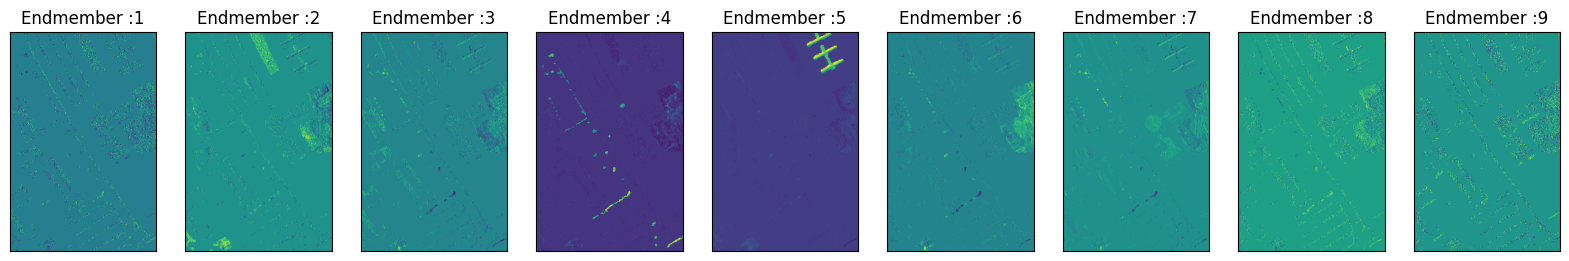

In [ ]:
abundance(thetaA)

In [ ]:
y = HSI_flat
y_estA = X.dot(thetaA.T).transpose()

print('The mean reconstruction error is :', round(error(y, y_estA),3))

The mean reconstruction error is : 118783.181


In [ ]:
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

In [ ]:
constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})

In [ ]:
thetaB = np.zeros((pixels,9))
X = endmembers
y = HSI_flat[i,:]
x_nnls, rnorm = nnls(X, y)

for i in range(pixels):
    if labels[i]!=0:
        y = HSI_flat[i,:]
        thetaB[i] = minimize(fn, x0=x_nnls, args = (X,y), method = 'SLSQP', constraints = constraints).x

In [ ]:
print(thetaB)
print(thetaB[99])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[ 2.66012594e+00  7.57046840e-01  9.86837629e-01 -1.66018153e-02
  7.18552925e-04  4.44028758e-02 -9.72693783e-01 -1.86054067e+00
 -5.99295568e-01]


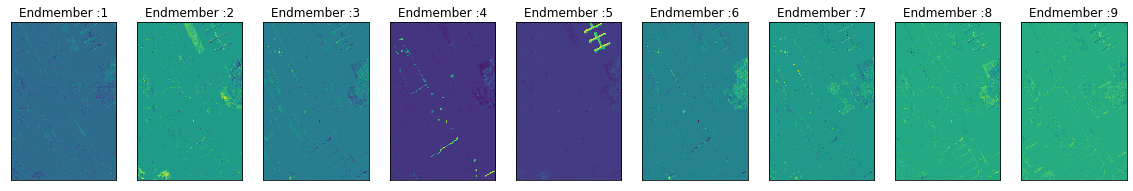

In [ ]:
abundance(thetaB)

In [ ]:
y = HSI_flat
y_estB = X.dot(thetaB.T).transpose()

print('The mean reconstruction error is :', round(error(y, y_estB),3))

The mean reconstruction error is : 160049.931


In [ ]:
thetaC = np.zeros((pixels,9))

for i in range(pixels):
    if labels[i]!=0:
        y = HSI_flat[i,:]
        x_nnls, rnorm = nnls(X, y)
        thetaC[i] = x_nnls

In [ ]:
print(thetaC)
print(thetaC[99])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0.         0.86639606 0.11691542 0.         0.         0.
 0.         0.         0.26364118]


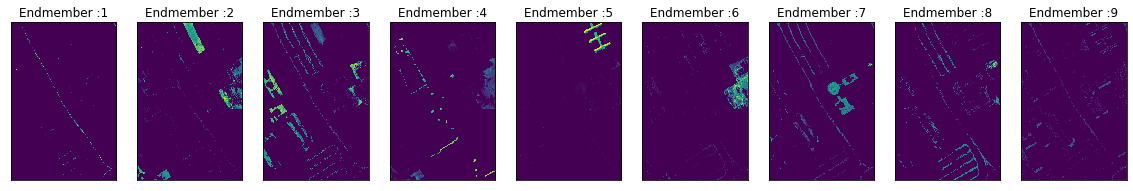

In [ ]:
abundance(thetaC)

In [ ]:
y = HSI_flat
y_estC = X.dot(thetaC.T).transpose()

print('The mean reconstruction error is :', round(error(y, y_estC),3))

The mean reconstruction error is : 569339.291


In [ ]:
def fn(x, A, b):
    return np.linalg.norm(A.dot(x) - b)

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1})

In [ ]:
bounds = [(0., sys.float_info.max) for x in x_nnls]

In [ ]:
thetaD = np.zeros((pixels,9))

y = HSI_flat[i,:]
x_nnls, rnorm = nnls(X, y)

for i in range(pixels):
    if labels[i]!=0:
        y = HSI_flat[i,:]
        thetaD[i] = minimize(fn, x0=x_nnls, args = (X,y), method = 'SLSQP', constraints = cons, bounds = bounds).x

In [ ]:
print(thetaD)
print(thetaD[99])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[6.63638927e-06 0.00000000e+00 7.36058713e-03 8.49649420e-01
 6.80851565e-02 1.14528177e-01 3.11714409e-03 9.85744270e-03
 1.81521985e-05]


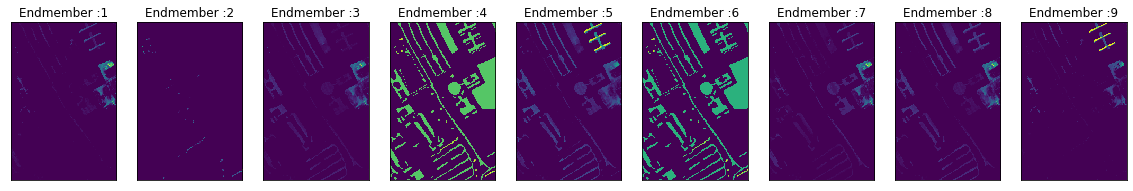

In [ ]:
abundance(thetaD)

In [ ]:
y = HSI_flat
y_estD = X.dot(thetaD.T).transpose()

print('The mean reconstruction error is :', round(error(y, y_estD),3))

The mean reconstruction error is : 99392525.493


In [ ]:
X = endmembers
thetaE = np.zeros((pixels,9))

for i in range(pixels):
    if labels[i]>=0:
        y = HSI_flat[i,:]
        clf = Lasso(alpha = 0.01, positive =True, fit_intercept=False, max_iter = 1e7)
        clf.fit(X,y)
        thetaE[i] = clf.coef_

In [ ]:
print(thetaE)
print(thetaE[99])

[[0.         0.37148733 0.02617406 ... 0.         0.         0.03812831]
 [0.         0.09703562 0.22764319 ... 0.         0.         0.05958018]
 [0.         0.         0.17973425 ... 0.         0.         0.05077734]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[0.         0.86690574 0.11660544 0.         0.         0.
 0.         0.         0.26263571]


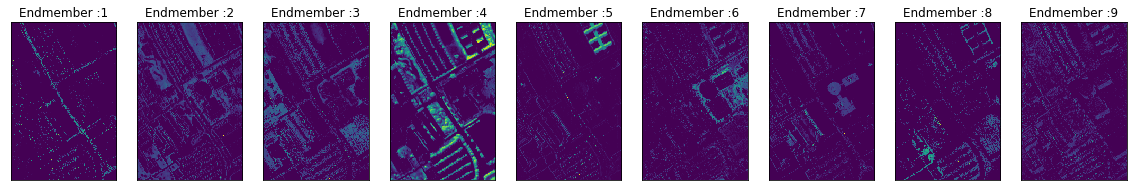

In [ ]:
abundance(thetaE)

In [ ]:
y = HSI_flat
y_estE = X.dot(thetaE.T).transpose()

print('The mean reconstruction error is :', round(error(y, y_estE),3))

The mean reconstruction error is : 570530.294


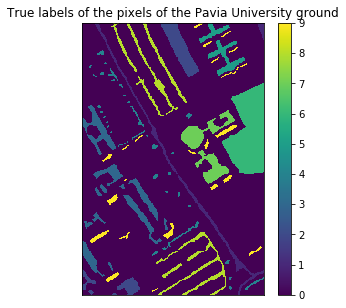

In [ ]:
fig = plt.figure(figsize = (5,5))
plt.imshow(ground_truth['y'])
plt.title('True labels of the pixels of the Pavia University ground')
plt.colorbar()
plt.xticks(())
plt.yticks(())
plt.show()

In [ ]:
Pavia_labels = sio.loadmat('classification_labels_Pavia.mat')
Training_Set = (np.reshape(Pavia_labels['training_set'],(200,300))).T
Test_Set = (np.reshape(Pavia_labels['test_set'],(200,300))).T
Operational_Set = (np.reshape(Pavia_labels['operational_set'],(200,300))).T

[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


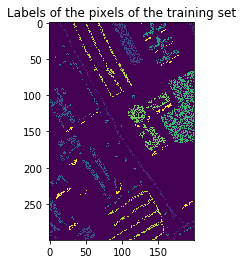

In [ ]:
print(Training_Set)
fig = plt.figure()
plt.imshow(Training_Set)
plt.title('Labels of the pixels of the training set')
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


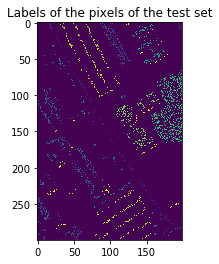

In [ ]:
print(Test_Set)
fig = plt.figure()
plt.imshow(Test_Set)
plt.title('Labels of the pixels of the test set')
plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


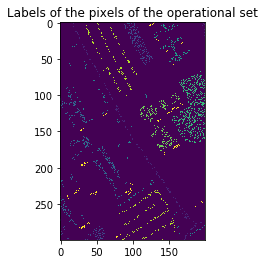

In [ ]:
print(Operational_Set)
fig = plt.figure()
plt.imshow(Operational_Set)
plt.title('Labels of the pixels of the operational set')
plt.show()

In [ ]:
Training_Set_reshaped = Training_Set.reshape((pixels,1))
print('Training set reshaped:')
print(Training_Set_reshaped[10:20])
print('--------------------------')
Test_Set_reshaped = Test_Set.reshape((pixels,1))
print('Test set reshaped:')
print(Test_Set_reshaped[10:20])
print('--------------------------')
Operational_Set_reshaped = Operational_Set.reshape((pixels,1))
print('Operational set reshaped:')
print(Operational_Set_reshaped[10:20])

Training set reshaped:
[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]]
--------------------------
Test set reshaped:
[[0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]]
--------------------------
Operational set reshaped:
[[0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]]


In [ ]:
X_train = np.empty((0,103))
y_train =  np.empty((0,1))

for i in range(pixels):
    if Training_Set_reshaped[i]!=0:
        X_train = np.append(X_train, [HSI_flat[i,:]], axis = 0)
        y_train = np.append(y_train, [Training_Set_reshaped[i]], axis = 0)

print('Train set X:')
print(X_train[0:5])
print('------------------------------------------------------------------')
print('Train set y:')
print(y_train[0:5])

Train set X:
[[1512. 1384. 1113. 1151. 1266. 1252. 1263. 1284. 1275. 1273. 1284. 1265.
  1222. 1219. 1208. 1185. 1215. 1236. 1234. 1272. 1295. 1273. 1296. 1305.
  1304. 1339. 1362. 1361. 1356. 1381. 1398. 1398. 1388. 1396. 1422. 1418.
  1428. 1463. 1466. 1467. 1497. 1506. 1502. 1502. 1508. 1509. 1495. 1482.
  1483. 1488. 1481. 1498. 1526. 1542. 1538. 1544. 1553. 1550. 1538. 1524.
  1522. 1535. 1544. 1530. 1538. 1568. 1572. 1554. 1560. 1562. 1565. 1547.
  1539. 1561. 1599. 1626. 1615. 1588. 1565. 1556. 1552. 1532. 1511. 1592.
  1677. 1664. 1636. 1620. 1610. 1600. 1595. 1587. 1580. 1573. 1574. 1557.
  1539. 1548. 1550. 1572. 1560. 1563. 1580.]
 [1502. 1425. 1305. 1278. 1313. 1279. 1285. 1280. 1292. 1319. 1300. 1284.
  1298. 1313. 1309. 1283. 1264. 1264. 1286. 1303. 1330. 1336. 1338. 1378.
  1389. 1368. 1369. 1388. 1406. 1408. 1422. 1450. 1457. 1439. 1423. 1433.
  1463. 1479. 1471. 1461. 1460. 1465. 1476. 1466. 1450. 1453. 1462. 1456.
  1440. 1447. 1507. 1546. 1525. 1482. 1454. 1457. 1455

In [ ]:
X_test = np.empty((0,103))
y_test =  np.empty((0,1))

for i in range(pixels):
    if Test_Set_reshaped[i]!=0:
        X_test= np.append(X_test, [HSI_flat[i,:]], axis = 0)
        y_test = np.append(y_test, [Test_Set_reshaped[i]], axis = 0)

print('Test set X:')
print(X_test[0:5])
print('--------------------------------------------------------------')
print('Test set y:')
print(y_test[0:5])

Test set X:
[[1351. 1214. 1293. 1482. 1389. 1330. 1322. 1287. 1334. 1365. 1324. 1230.
  1179. 1175. 1204. 1222. 1258. 1291. 1296. 1304. 1313. 1333. 1334. 1307.
  1315. 1325. 1311. 1304. 1316. 1322. 1331. 1351. 1361. 1361. 1363. 1377.
  1392. 1389. 1375. 1378. 1415. 1417. 1404. 1394. 1377. 1385. 1398. 1392.
  1387. 1384. 1383. 1365. 1358. 1391. 1410. 1401. 1393. 1406. 1411. 1409.
  1398. 1397. 1410. 1412. 1393. 1376. 1381. 1393. 1414. 1411. 1411. 1402.
  1412. 1448. 1464. 1467. 1457. 1466. 1487. 1469. 1466. 1418. 1371. 1452.
  1533. 1509. 1482. 1480. 1494. 1480. 1455. 1461. 1434. 1429. 1431. 1410.
  1407. 1418. 1424. 1442. 1477. 1512. 1499.]
 [1462. 1231. 1272. 1356. 1274. 1250. 1312. 1212. 1112. 1104. 1180. 1220.
  1223. 1220. 1243. 1245. 1241. 1268. 1300. 1278. 1211. 1177. 1205. 1213.
  1200. 1245. 1272. 1250. 1229. 1259. 1316. 1313. 1293. 1311. 1343. 1367.
  1359. 1346. 1335. 1339. 1367. 1389. 1393. 1382. 1375. 1398. 1414. 1426.
  1437. 1414. 1416. 1441. 1442. 1427. 1412. 1413. 1435.

In [ ]:
Operational_Set_reshaped = Operational_Set.reshape((pixels,1))
X_operation = np.empty((0,103))
y_operation =  np.empty((0,1))

for i in range(pixels):
    if Operational_Set_reshaped[i]!=0:
        X_operation= np.append(X_operation, [HSI_flat[i,:]], axis = 0)
        y_operation = np.append(y_operation, [Operational_Set_reshaped[i]], axis = 0)

print('Operation set X:')
print(X_operation[0:5])
print('--------------------------------------------------------------')
print('Operation set y:')
print(y_operation[0:5])

Operation set X:
[[1377. 1379. 1425. 1467. 1427. 1302. 1258. 1245. 1268. 1276. 1214. 1199.
  1270. 1265. 1224. 1231. 1239. 1193. 1167. 1193. 1206. 1247. 1266. 1248.
  1258. 1244. 1234. 1264. 1296. 1282. 1264. 1260. 1283. 1319. 1321. 1331.
  1334. 1323. 1327. 1339. 1338. 1328. 1325. 1328. 1337. 1362. 1363. 1336.
  1334. 1340. 1361. 1381. 1370. 1325. 1324. 1353. 1375. 1398. 1407. 1385.
  1389. 1407. 1428. 1415. 1397. 1408. 1401. 1396. 1423. 1440. 1434. 1375.
  1362. 1398. 1434. 1468. 1476. 1481. 1488. 1497. 1493. 1465. 1452. 1493.
  1560. 1536. 1515. 1506. 1485. 1460. 1456. 1462. 1489. 1509. 1524. 1470.
  1448. 1464. 1469. 1472. 1461. 1466. 1439.]
 [1541. 1390. 1333. 1371. 1326. 1263. 1225. 1233. 1221. 1197. 1192. 1235.
  1252. 1245. 1256. 1298. 1319. 1293. 1259. 1253. 1276. 1287. 1292. 1304.
  1304. 1323. 1329. 1336. 1345. 1349. 1342. 1324. 1324. 1346. 1362. 1369.
  1398. 1403. 1382. 1372. 1390. 1415. 1404. 1388. 1393. 1391. 1387. 1371.
  1374. 1384. 1396. 1415. 1416. 1407. 1408. 1428. 

In [ ]:
NB_score = cross_val_score(GaussianNB(), X_train, y_train.reshape(-1), cv = 10)
NB_error = 1 - NB_score
NB_mean = round(NB_error.mean(),3)
NB_std = round(NB_error.std(),3)
print('Naive Bayes validation error is:', NB_mean)
print('Naive Bayes error standard deviation error is:', NB_std)

Naive Bayes validation error is: 0.355
Naive Bayes error standard deviation error is: 0.057


In [ ]:
NB_model = GaussianNB()
NB_model.fit(X_train, y_train.reshape(-1))
NB_predictions = NB_model.predict(X_test)
print('Some Naive Bayes predictions ',NB_predictions[0:5])

Some Naive Bayes predictions  [7. 7. 8. 8. 2.]


In [ ]:
NB_cm = confusion_matrix(y_test, NB_predictions)
print('Naive Bayes Confusion Matrix:')
print(NB_cm)

Naive Bayes Confusion Matrix:
[[131   0  37   0   0   0  80  13   0]
 [  0 326   4   6   0  17   0   0   0]
 [ 25   2 127   0   0  13  70 299   0]
 [  0   0   0 154   1   1   0   0   0]
 [  0   0   1   0 166   1   0   0   0]
 [  0 312   2  55  32 363   0   0   0]
 [ 18   0  26   0   0   0 277   0   0]
 [  2   1  67   0   0   1   2 388   0]
 [  0   0   0   2   0   0   0   0 185]]


Next we calculate the succes rate as adviced by the exercise

In [ ]:
#numpy trace function returns the sum of the diagonal elements
#numpy sum function returns the sum of all the elements
NB_sc = np.trace(NB_cm)/ np.sum(NB_cm)
print('Naive Bayes classifier success rate is:',NB_sc)

Naive Bayes classifier success rate is: 0.660118490801372


In [ ]:
def get_class_means(X,y):
    X_per_class = np.empty((0,103))
    x_means = np.empty((0,103))

    for label in range(1,10):
        for i in range(X.shape[0]):
            if y[i]== label:
                X_per_class = np.append(X_per_class, [X[i]], axis = 0)
        mean_per_class = np.mean(X_per_class, axis = 0)
        x_means = np.append(x_means, [mean_per_class], axis = 0)
        X_per_class = np.empty((0,103))
    return x_means

In [ ]:
def classify_dist(min_dist, dist):
    if min_dist == dist[0]:
        return 1
    elif min_dist == dist[1]:
        return 2
    elif min_dist == dist[2]:
        return 3
    elif min_dist == dist[3]:
        return 4
    elif min_dist == dist[4]:
        return 5
    elif min_dist == dist[5]:
        return 6
    elif min_dist == dist[6]:
        return 7
    elif min_dist == dist[7]:
        return 8
    else:
        return 9

In [ ]:
kf = KFold(n_splits=10)
errors_cv = np.empty((0,1))

#now for the cross validation part

for i, j in kf.split(X_train, y_train):
    X_train_cv = X_train[i]
    y_train_cv = y_train[i]
    X_test_cv = X_train[j]
    y_test_cv = y_train[j]
    C = X_test_cv.shape[0]

    class_means = get_class_means(X_train_cv, y_train_cv)

    MED_pred = np.empty((0,1))

    dist = np.empty((C,9))

    for i in range(C):
        for j in range(9):
            dist[i,j] = np.linalg.norm(X_test_cv[i] - class_means[j])**2
            min_dist = np.min(dist[i,:])

        MED_pred = np.append(MED_pred,classify_dist(min_dist, dist[i]))

    count_errors = 0

    for k in range(C):
        diff = y_test_cv[k] - MED_pred[k]
        if diff == 0:
            continue
        else:
            count_errors +=1

    prob_error = count_errors / C
    errors_cv = np.append(errors_cv, prob_error)


MED_mean = round(np.mean(errors_cv),3)
MED_std = round(np.std(errors_cv),3)

print('The Minimum Euclidean distance classifier validation error is', MED_mean)
print('The Minimum Euclidean distance classifier standard deviation validation error is', MED_std)

The Minimum Euclidean distance classifier validation error is 0.465
The Minimum Euclidean distance classifier standard deviation validation error is 0.105


In [ ]:
MED_class_means = get_class_means(X_train, y_train)
D =  X_test.shape[0]
med_pred2 = np.empty((0,1))
dist = np.empty((D,9))

for i in range(D):
    for j in range(9):
        dist[i,j] = np.linalg.norm(X_test[i] - MED_class_means[j])**2
        min_dist = np.min(dist[i,:])

    med_pred2 = np.append(med_pred2,classify_dist(min_dist, dist[i]))

MED_cm = confusion_matrix(y_test, med_pred2)
print('Minimum Euclidean Distance classifier confusion matrix:')
print(MED_cm)

Minimum Euclidean Distance classifier confusion matrix:
[[152   0  46   0   0   0  61   2   0]
 [  1 188   0   5   0 156   0   3   0]
 [ 66   2 198   0   0   1  39 230   0]
 [  0   0   0 154   0   0   0   0   2]
 [  0   0   0   0 128   0   0  40   0]
 [ 11 317   0  12  16 240   0 168   0]
 [ 61   0  23   0   0   0 237   0   0]
 [  2   1 145   0   0   1   7 305   0]
 [  0   0   0   0   0   0   0   0 187]]


In [ ]:
MED_sc = np.trace(MED_cm)/ np.sum(MED_cm)
print('Minimum euclidean distance classifier success rate is:', MED_sc)

Minimum euclidean distance classifier success rate is: 0.5578422201434362


In [ ]:
KNN_score = cross_val_score(KNeighborsClassifier(n_neighbors=9), X_train, y_train.reshape(-1), cv = 10)
KNN_error = 1 - KNN_score
KNN_mean = round(KNN_error.mean(),3)
KNN_std = round(KNN_error.std(),3)
print('KNN validation error mean is:', KNN_mean)
print('KNN error standard deviation error is:', KNN_std)

KNN validation error mean is: 0.148
KNN error standard deviation error is: 0.05


In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=9)
KNN_model.fit(X_train, y_train.reshape(-1))
KNN_predictions = KNN_model.predict(X_test)
print('Some KNN predictions ',KNN_predictions[0:5])

KNN_cm = confusion_matrix(y_test, KNN_predictions)
print('KNN Confusion Matrix:')
print(KNN_cm)

Some KNN predictions  [1. 1. 8. 8. 2.]
KNN Confusion Matrix:
[[188   0  13   0   0   0  28  32   0]
 [  0 323   0   1   0  28   0   1   0]
 [ 11   2 446   0   0   5   1  71   0]
 [  0   0   0 155   0   1   0   0   0]
 [  0   0   1   0 166   0   0   1   0]
 [  0  63   1   0   1 697   0   2   0]
 [ 13   0   5   0   0   0 301   2   0]
 [  9   2  88   0   0   0   2 360   0]
 [  0   0   0   0   0   0   0   0 187]]


In [ ]:
KNN_sc = np.trace(KNN_cm)/ np.sum(KNN_cm)
print('KNN classifier success rate is:',KNN_sc)

KNN classifier success rate is: 0.8802619270346118


In [ ]:
B_score = cross_val_score(QuadraticDiscriminantAnalysis(), X_train, y_train.reshape(-1), cv = 10)
B_error = 1 - B_score
B_mean = round(B_error.mean(),3)
B_std = round(B_error.std(),3)
print('Bayes validation error is:', B_mean)
print('Bayes error standard deviation error is:', B_std)

Bayes validation error is: 0.144
Bayes error standard deviation error is: 0.029


In [ ]:
B_model = QuadraticDiscriminantAnalysis()
B_model.fit(X_train, y_train.reshape(-1))
B_predictions = B_model.predict(X_test)
print('Some Bayes classifier predictions ',B_predictions[0:5])

B_cm = confusion_matrix(y_test, B_predictions)
print('Bayes classifier Confusion Matrix:')
print(B_cm)

Some Bayes classifier predictions  [1. 1. 8. 3. 6.]
Bayes classifier Confusion Matrix:
[[155   0  46   0   0   2  10  48   0]
 [  0 328   0   3   0  22   0   0   0]
 [ 10   1 430   0   0   0   0  95   0]
 [  0   0   0 154   0   2   0   0   0]
 [  0   0   0   0 168   0   0   0   0]
 [  0   1   0   1   0 762   0   0   0]
 [ 14   0  10   0   0   2 291   4   0]
 [ 19   0  73   0   0   2   0 367   0]
 [  3   0   0   1   2   0   0   0 181]]


In [ ]:
B_sc = np.trace(B_cm)/ np.sum(B_cm)
print('Bayes classifier success rate is:',B_sc)

Bayes classifier success rate is: 0.8843155597131276


In [ ]:
print('Naive Bayes classifier success rate is:',NB_sc)
print('Minimum euclidean distance classifier success rate is:', MED_sc)
print('KNN classifier success rate is:',KNN_sc)
print('Bayes classifier success rate is:',B_sc)

Naive Bayes classifier success rate is: 0.660118490801372
Minimum euclidean distance classifier success rate is: 0.5578422201434362
KNN classifier success rate is: 0.8802619270346118
Bayes classifier success rate is: 0.8843155597131276
